In [4]:
# чтение спектров и подготовка 

import os

directory = 'H:/Data/1_ДИПЛОМНАЯ РАБОТА/Интегрирование/Collimator_100_0_line' #
list_of_files = os.listdir(directory) #список файлов
bulls= []
for i in list_of_files:
    with open(directory + '/'+ i, 'r') as f:
        tmp=f.readlines()
        bulls.append(tmp)

chanel=[] # список массивов каналов
for j in bulls:
    a = j[0].split(' ') # чтение живого времени
    t = a[3] 
    t=t.replace(',', '.')
    time=float(t[:len(t)-2])
    #print('Живое время = ',time, ' секунд')
    ch = []           # список каналов
    for i in range(2,4098):  # чтение импульсов в каналах
        a = j[i].split(' ')
        ch.append(a[2])
    ch=list(map(float, ch))    
    ch=list(map(lambda x: x/time,ch))
    chanel.append(ch)
# сейчас у меня есть список из 11 элементов, каждый из которых это массив импульсов по каналам.   
# а последний элемент(12ый), это массив импульсов для фона 

# вычитаем фон 

for i in range(11):
    for p in range(4095):
        chanel[i][p]=chanel[i][p]-chanel[11][p]
        
import matplotlib.pyplot as plt
#%matplotlib inline        # выводит график в редакторе кода

In [6]:
# метод скользящего среднего

i=0
j=0
for i in range(11):
    for j in range(3,4092):
        chanel[i][j]=1/5*(sum([chanel[i][j-2],chanel[i][j-1],chanel[i][j],chanel[i][j+1],chanel[i][j+2]]))


In [15]:
# поиск констант и подсчет интеграла

from scipy.optimize import minimize
from scipy import integrate
import numpy as np

h=1 #высота от детектора до источника
chanel_out=[]
x=np.arange(0,1.1,0.1) 

f_out=open('koeff.txt', 'w')
f_tmpout_alpha=open('tmp_alpha.txt', 'w')
f_tmpout_beta=open('tmp_beta.txt', 'w')
f_tmplast_alpha=open('tmplast_alpha.txt', 'w')
f_tmplast_beta=open('tmplast_beta.txt', 'w')

ch_alpha=[]
ch_beta=[]

for p in range(4095):
    
    def f(x,alpha,beta):
         return alpha*h**(beta)/(h**2+x**2)**((beta+1)/2)
        
    def delta(alpha, beta):
        d=0
        for i in range(10):
            d=d+(f(x[i],alpha,beta)-chanel[i][p])**2 
        return d

    res=minimize(lambda x: delta(*x), [1,1])
    a=res.x[0]
    b=res.x[1]
    f_out.write(str(p) + '   alpha=' + str("%.4f" % a) + ' beta=' + str("%.4f" % b) + ',    ')
    f_tmpout_alpha.write(str("%.6f" % a) + '\n')
    f_tmpout_beta.write(str("%.6f" % b) + '\n')
  
    # получил альфа и бета для интерполирующей функции на всем интервале

    def g(x):
        return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+1)/2)
    
    carpet=integrate.quad(g,0,1)

    # проинтегрировал интерполирующую функцию на интервале (0,1)

    def f_last(x, alpha,beta):
        return alpha*h**(beta)/(h**2+x**2)**((beta+1)/2)

    def delta_last(alpha,beta):
        d=0
        for i in range(9,10):
            d=d+(f_last(x[i],alpha,beta)-chanel[i][p])**2 
        return d

    res_last=minimize(lambda x: delta_last(*x), [1,1])
    a=res_last.x[0]
    b=res_last.x[1]
    f_out.write('на последнем интервале alpha='+ str("%.4f" % a) + ', beta= ' + str("%.4f" % b) + '\n')
    ch_alpha.append(a)
    ch_beta.append(b)
    f_tmplast_alpha.write(str("%.6f" % a) + '\n')
    f_tmplast_beta.write(str("%.6f" % b) + '\n')
    
    # получил альфа и бета для последнего интервала

    def g_last(x):
        return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+1)/2)
    carpet_last=integrate.quad(g_last,1, np.inf)
    
    # проинтегрировал интерполирующую функцию с коэффициентами из последнего интервала по бесконечности
    
    chanel_out.append(carpet[0]+carpet_last[0])
    
f_integr=open('integr.txt', 'w')
f_integr.write('кэВ  ' + '  имп*м*м/с' + '\n')

for i in range(4095):
    f_integr.write(str(i) + '  ' + str("%.4f" % chanel_out[i]) + '\n')

    
f_out.close()
f_tmplast_alpha.close()    
f_tmplast_beta.close()
f_integr.close()
f_tmpout_alpha.close()
f_tmpout_beta.close()

In [32]:
# нахожу алфьа и бета для построения графиков зависимости альфа и бета от номера интервала
# костыли жуткие

ch_alpha_graph=[]
ch_beta_graph=[]

f_tmpout_alpha_graph=open('tmp_alpha_graph_460.txt', 'w')
f_tmpout_beta_graph=open('tmp_beta_graph_460.txt', 'w')

for j in range(10):    
        
        def f_graph(x, alpha,beta):
            return alpha*h**(beta)/(h**2+x**2)**((beta+1)/2)

        def delta_graph(alpha,beta):
            d=0
            for i in range(j,j+1):
                d=d+(f_graph(x[j],alpha,beta)-chanel[j][460])**2 
            return d

        res_graph=minimize(lambda x: delta_graph(*x), [1,1])
        a=res_graph.x[0]
        b=res_graph.x[1]
        ch_alpha_graph.append(a)
        ch_beta_graph.append(b)
        f_tmpout_alpha_graph.write(str("%.6f" % a) + '\n')
        f_tmpout_beta_graph.write(str("%.6f" % b) + '\n')
    
     #поправить то что дальше   
#fig=plt.figure(figsize=(20,10), dpi=100)
#plt.plot(np.arange(1,11,1), ch_alpha_graph)
#plt.xlabel('Номер интервала')
#plt.ylabel('Коэффициенты alpha')
#fig.savefig('alpha_graph_510', fmt='png')
    
#fig1=plt.figure(figsize=(20,10), dpi=100)
#plt.plot(np.arange(1,11,1), ch_beta_graph)
#plt.xlabel('Номер интервала')
#plt.ylabel('Коэффициенты beta')
#fig1.savefig('beta_graph_510', fmt='png')

f_tmpout_alpha_graph.close()
f_tmpout_beta_graph.close()

In [175]:
def g_last(x):
    a,b = 1.4147434979760465, 0.86660678985018
    return 2*np.pi*a*x*h**b/(h**2+x**2)**((b+1)/2)


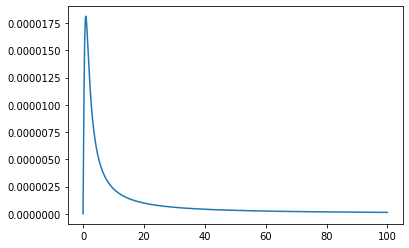

In [16]:
plt.plot(np.arange(0,100,0.01),g_last(np.arange(0,100,0.01)))

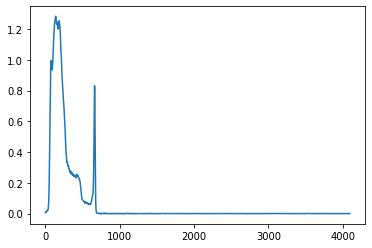

In [8]:
ch_tmp=[]
for j in range(4095):
    ch_tmp.append(chanel[0][j])

plt.plot(np.arange(1,4096,1), ch_tmp)

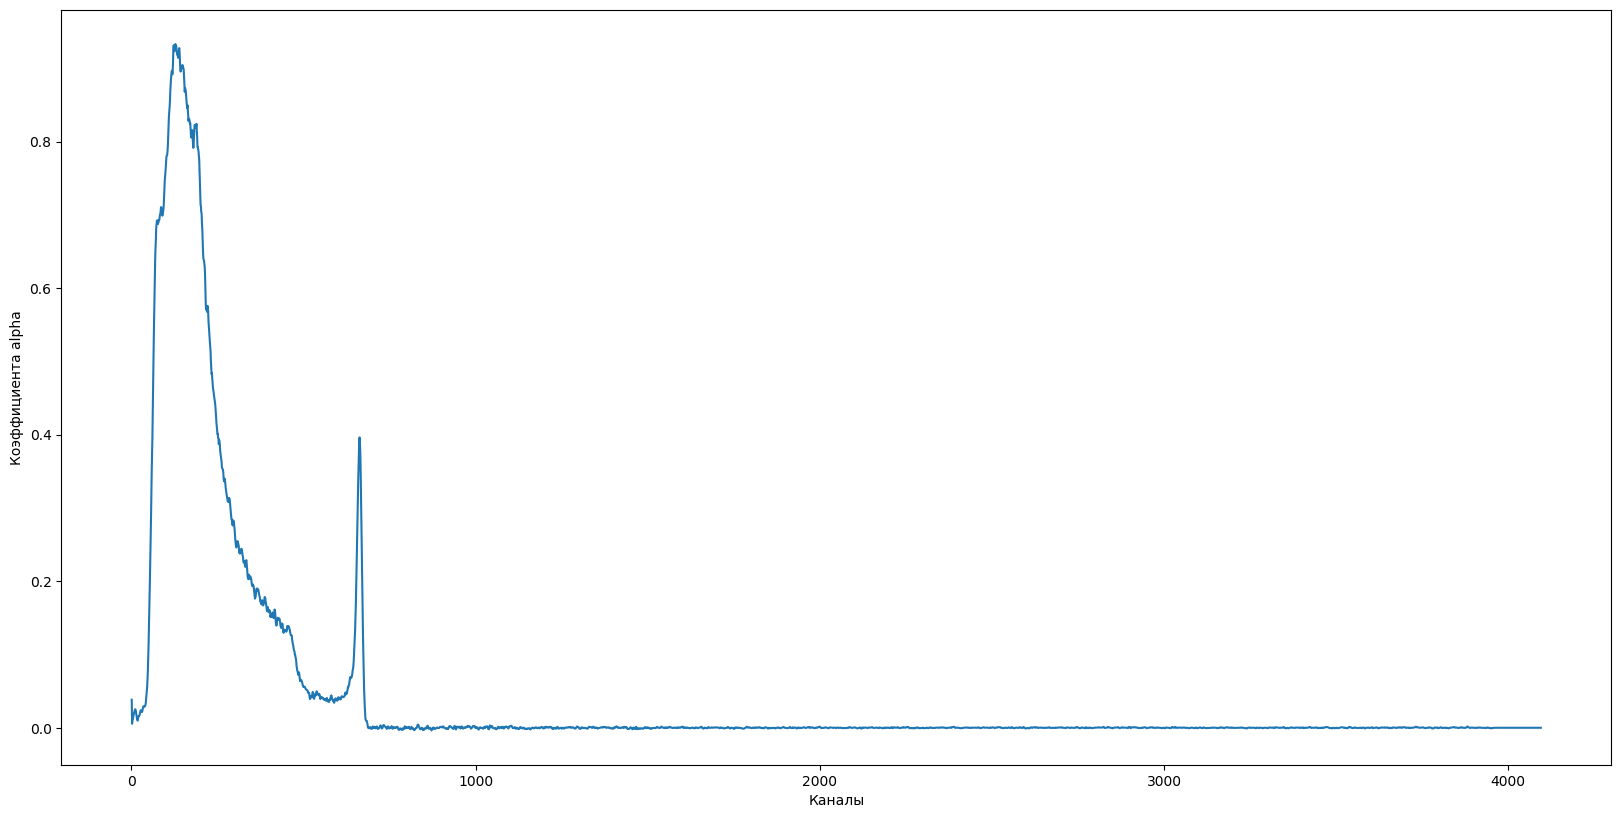

In [10]:
fig=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4096,1), ch_alpha)
plt.xlabel('Каналы')
plt.ylabel('Коэффициенты alpha')
fig.savefig('alpha', fmt='png')

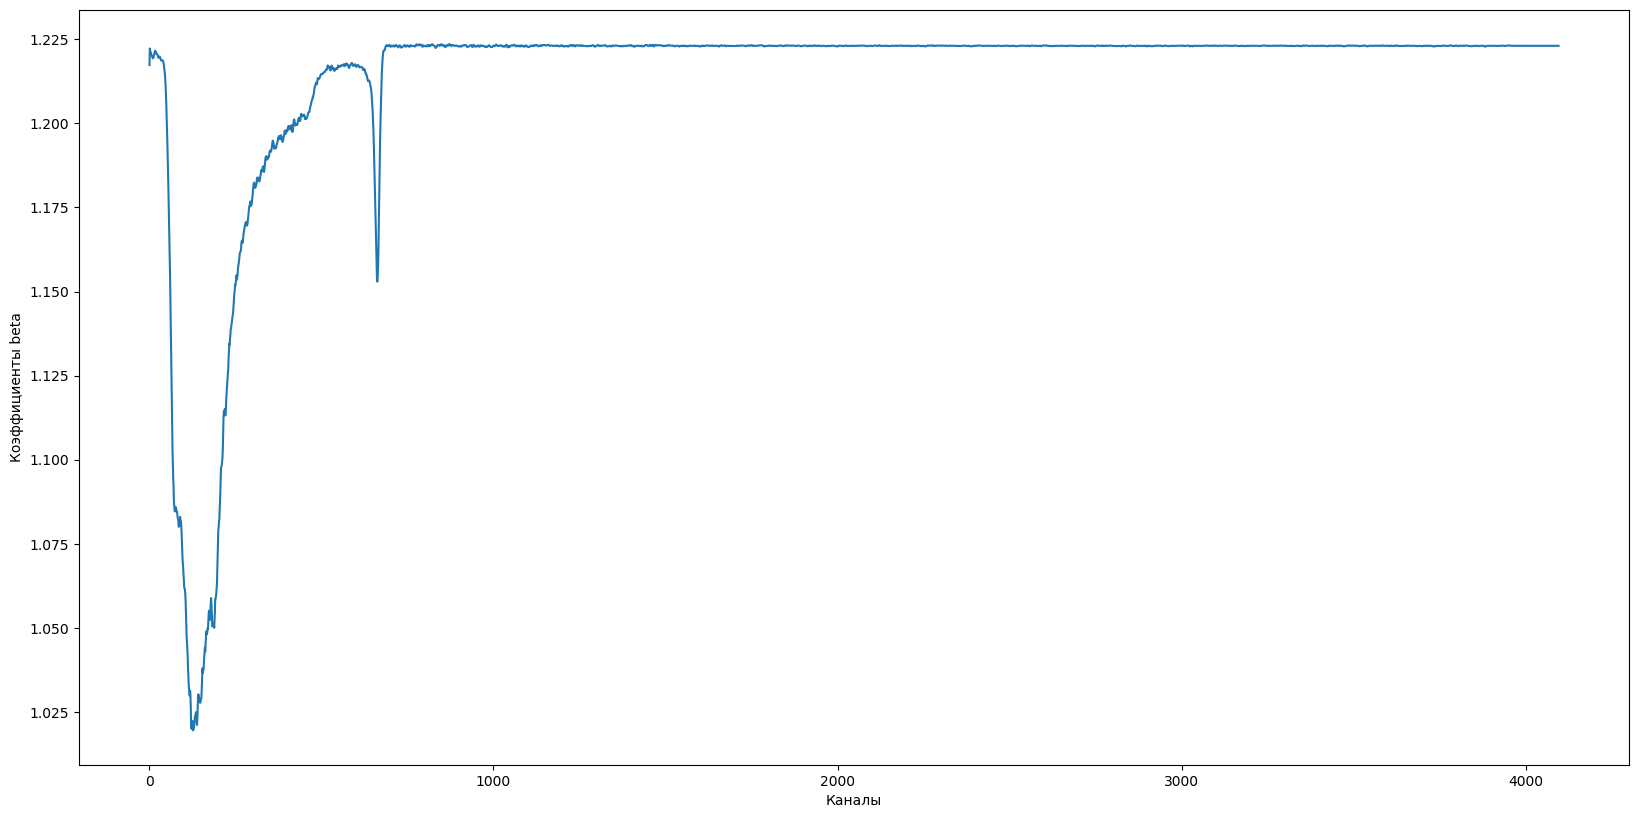

In [12]:
fig_1=plt.figure(figsize=(20,10), dpi=100)
plt.plot(np.arange(1,4096,1), ch_beta)
plt.xlabel('Каналы')
plt.ylabel('Коэффициенты beta')
fig_1.savefig('beta', fmt='png')